# Processing Data

## Load tokenizer

In [3]:
from datasets import load_dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import json

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ---------- Preprocesing Functions ----------
def preprocess_paradetox_multilingual(example):
    return {
        "input_text": "detoxify: " + example["toxic_sentence"],
        "target_text": example["neutral_sentence"]
    }

def preprocess_paradetox(example):
    return {
        "input_text": "detoxify: " + example["en_toxic_comment"],
        "target_text": example["en_neutral_comment"]
    }

def clean_columns(dataset):
    return dataset.remove_columns(
        [col for col in dataset.column_names if col not in ["input_text", "target_text"]]
    )


def load_json_results(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)


def save_variables_to_json(filename, **variables):
    """
    Saves given variables to a JSON file with their variable names as keys.

    Parameters:
    - filename (str): The name of the JSON file to write to.
    - **variables: Arbitrary keyword arguments representing variable names and their values.
    """
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(variables, f, ensure_ascii=False, indent=2)

ImportError: 
T5Tokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


## Load and Process Datasets

In [2]:
# ---------- Load and Process Datasets ----------
test_data_en = load_dataset("textdetox/multilingual_paradetox", split="en")
test_data_de = load_dataset("textdetox/multilingual_paradetox", split="de")
train_data = load_dataset("s-nlp/paradetox", split="train") 

In [3]:
save_variables_to_json(
    "test_data_en.json",
    toxic_texts=test_data_en["toxic_sentence"],
    human_texts=test_data_en["neutral_sentence"],
)

## Reformat data

In [4]:
import json

# Load the original test data
with open("test_data_en.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Reformat into list of {"input_text": ..., "target_text": ...}
reformatted = [
    {"input_text": toxic.strip(), "target_text": neutral.strip()}
    for toxic, neutral in zip(test_data["toxic_texts"], test_data["human_texts"])
]

# Save the reformatted structure
with open("test_data_en2.json", "w", encoding="utf-8") as f:
    json.dump(reformatted, f, indent=2, ensure_ascii=False)

print("✅ Saved as 'test_data_en2.json'")

✅ Saved as 'test_data_en2.json'


## format datasets remove emoji

In [5]:
import re

formatted_train = clean_columns(train_data.map(preprocess_paradetox))
formatted_en = clean_columns(test_data_en.map(preprocess_paradetox_multilingual))
formatted_de = clean_columns(test_data_de.map(preprocess_paradetox_multilingual))


def remove_emojis(text):
    # This regex pattern matches a wide range of emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def clean_emoji_batch(batch):
    batch["input_text"] = remove_emojis(batch["input_text"])
    batch["target_text"] = remove_emojis(batch["target_text"])
    return batch

formatted_train = formatted_train.map(clean_emoji_batch)
formatted_en = formatted_en.map(clean_emoji_batch)
formatted_de = formatted_de.map(clean_emoji_batch)


In [6]:
print("Test dataset en size:", len(formatted_en))
print("Test dataset de size:", len(formatted_de))
print("Train dataset size:", len(formatted_train))

print("Test en dataset columns:", formatted_en.column_names)
print("Test de dataset columns:", formatted_de.column_names)
print("Train dataset columns:", formatted_train.column_names)

Test dataset en size: 400
Test dataset de size: 400
Train dataset size: 19744
Test en dataset columns: ['input_text', 'target_text']
Test de dataset columns: ['input_text', 'target_text']
Train dataset columns: ['input_text', 'target_text']


## Save datasets to json

In [7]:
save_variables_to_json(
    "formatted_de.json",
    input_texts=formatted_de["input_text"],
    reference_texts=formatted_de["target_text"],
)

save_variables_to_json(
    "formatted_en.json",
    input_texts=formatted_en["input_text"],
    reference_texts=formatted_en["target_text"],
)

save_variables_to_json(
    "formatted_train.json",
    input_texts=formatted_train["input_text"],
    reference_texts=formatted_train["target_text"],
)

## Load Dataset

In [4]:
import json
from datasets import Dataset

def load_formatted_json(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Convert keys to the structure used by your pipeline
    input_texts = data["input_texts"]
    target_texts = data["reference_texts"]

    return Dataset.from_dict({
        "input_text": input_texts,
        "target_text": target_texts
    })

formatted_train = load_formatted_json("formatted_train.json")
formatted_de = load_formatted_json("formatted_de.json")
formatted_en = load_formatted_json("formatted_en.json")

In [5]:
def tokenize(examples):
    # Tokenize inputs
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=128,
        padding="max_length",
        truncation=True
    )

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target_text"],
            max_length=128,
            padding="max_length",
            truncation=True
        )

    # Mask padding tokens in labels
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label_seq]
        for label_seq in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize dataset
tokenized_dataset = formatted_train.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.filter(lambda x: any(label != -100 for label in x["labels"]))

tokenized_eval = formatted_en.map(tokenize, batched=True)
tokenized_eval = tokenized_eval.filter(lambda x: any(label != -100 for label in x["labels"]))

# Assign to eval_dataset
eval_dataset = tokenized_eval
train_dataset = tokenized_dataset

Map:   0%|          | 0/19744 [00:00<?, ? examples/s]


NameError: name 'tokenizer' is not defined

In [10]:
print("Train dataset size:", len(train_dataset))
print("Eval dataset size:", len(eval_dataset))

print(type(eval_dataset))
print(eval_dataset[1])

print(type(train_dataset))
print(train_dataset[1])

Train dataset size: 19744
Eval dataset size: 400
<class 'datasets.arrow_dataset.Dataset'>
{'input_text': "detoxify: My page should be protected first so that worthless scum like you can't keep vandalizing it.", 'target_text': "My page should be protected first so that unpleasant people like you can't keep vandalizing it.", 'input_ids': [16379, 4921, 10, 499, 543, 225, 36, 5046, 166, 78, 24, 1494, 924, 3, 7, 6361, 114, 25, 54, 31, 17, 453, 4049, 26, 138, 2610, 34, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Models

## finetuned transformer model

In [11]:
print("Train dataset columns:", train_dataset.column_names)
print("Eval dataset columns:", eval_dataset.column_names)

Train dataset columns: ['input_text', 'target_text', 'input_ids', 'attention_mask', 'labels']
Eval dataset columns: ['input_text', 'target_text', 'input_ids', 'attention_mask', 'labels']


# GPT2

In [11]:
# Load the English evaluation dataset
with open("evaluation_dataset_english.json", "r", encoding="utf-8") as f:
    evaluation_dataset_english = json.load(f)

# Load the German evaluation dataset
with open("evaluation_dataset_german.json", "r", encoding="utf-8") as f:
    evaluation_dataset_german = json.load(f)

# Now these should work
input_texts = evaluation_dataset_english["input_text"]
reference_texts = evaluation_dataset_english["target_text"]

TypeError: list indices must be integers or slices, not str

In [10]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token by default
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.to(device)


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # GPT2 is a causal LM
)


In [ ]:
# Load tokenizer and model
from transformers import T5ForConditionalGeneration, T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from transformers import (
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer,
)

import torch
import warnings

from math import pi, cos

warnings.filterwarnings("ignore", category=FutureWarning)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-detox-en-finetuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    num_train_epochs=6,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_en_refined",
    report_to="none"
)

# ✅ Custom Trainer with full-batch penalty, lambda warmup, and logging
class ToxicityPenaltyTrainer(Seq2SeqTrainer):
    def __init__(self, *args, lambda_penalty=0.5, warmup_steps=500, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_penalty = lambda_penalty
        self.warmup_steps = warmup_steps
        self.tox_tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
        self.tox_model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert").to(self.model.device)
        self.tox_model.eval()
        self.current_step = 0
        self.penalty_log = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        generation_loss = outputs.loss
        self.current_step += 1

        # Delay penalty until warmup is complete
        if self.current_step < self.warmup_steps:
            return (generation_loss, outputs) if return_outputs else generation_loss

        # Full batch generation
        sample_input_ids = inputs["input_ids"]
        sample_attention_mask = inputs["attention_mask"]

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=sample_input_ids,
                attention_mask=sample_attention_mask,
                max_length=64,
                num_beams=4,
                do_sample=False,
                early_stopping=True,
            )
            decoded_texts = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            tox_inputs = self.tox_tokenizer(decoded_texts, return_tensors="pt", truncation=True, padding=True).to(self.model.device)
            tox_logits = self.tox_model(**tox_inputs).logits
            tox_probs = torch.sigmoid(tox_logits[:, 0])
            excess_tox = (tox_probs - 0.2).clamp(min=0)
            penalty = excess_tox.mean()

        # Apply simple weighted penalty (no tanh)
        total_loss = generation_loss + self.lambda_penalty * penalty

        # Log losses and penalty
        self.log({
            "generation_loss": generation_loss.item(),
            "penalty_score": penalty.item(),
            "penalty_weight": (self.lambda_penalty * penalty).item()
        })
        self.penalty_log.append({
            "step": self.state.global_step,
            "epoch": self.state.epoch,
            "generation_loss": generation_loss.item(),
            "penalty_score": penalty.item()
        })

        return (total_loss, outputs) if return_outputs else total_loss

# ✅ Instantiate and train
trainer = ToxicityPenaltyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    lambda_penalty=0.5
    )

trainer.train()

  0%|          | 0/1848 [00:00<?, ?it/s]

{'loss': 1.6705, 'grad_norm': 1.7095847129821777, 'learning_rate': 2.8409090909090912e-05, 'epoch': 0.32}
{'loss': 1.3577, 'grad_norm': 7.922150135040283, 'learning_rate': 2.6785714285714288e-05, 'epoch': 0.65}
{'generation_loss': 1.273884654045105, 'penalty_score': 0.31782108545303345, 'penalty_weight': 0.15891054272651672, 'epoch': 0.81}
{'generation_loss': 1.1391862630844116, 'penalty_score': 0.3057519793510437, 'penalty_weight': 0.15287598967552185, 'epoch': 0.81}
{'generation_loss': 1.1801512241363525, 'penalty_score': 0.3209766149520874, 'penalty_weight': 0.1604883074760437, 'epoch': 0.81}
{'generation_loss': 1.2440648078918457, 'penalty_score': 0.41914278268814087, 'penalty_weight': 0.20957139134407043, 'epoch': 0.81}
{'generation_loss': 1.555008053779602, 'penalty_score': 0.39289867877960205, 'penalty_weight': 0.19644933938980103, 'epoch': 0.81}
{'generation_loss': 1.4147517681121826, 'penalty_score': 0.35227668285369873, 'penalty_weight': 0.17613834142684937, 'epoch': 0.82}
{'

  0%|          | 0/50 [00:00<?, ?it/s]

{'generation_loss': 1.4686201810836792, 'penalty_score': 0.36088669300079346, 'penalty_weight': 0.18044334650039673, 'epoch': 1.0}
{'generation_loss': 2.2466468811035156, 'penalty_score': 0.6099547147750854, 'penalty_weight': 0.3049773573875427, 'epoch': 1.0}
{'generation_loss': 1.0380563735961914, 'penalty_score': 0.2884753942489624, 'penalty_weight': 0.1442376971244812, 'epoch': 1.0}
{'generation_loss': 1.4138147830963135, 'penalty_score': 0.45770683884620667, 'penalty_weight': 0.22885341942310333, 'epoch': 1.0}
{'generation_loss': 1.0097635984420776, 'penalty_score': 0.1947643756866455, 'penalty_weight': 0.09738218784332275, 'epoch': 1.0}
{'generation_loss': 1.193180799484253, 'penalty_score': 0.16215690970420837, 'penalty_weight': 0.08107845485210419, 'epoch': 1.0}
{'generation_loss': 1.1036885976791382, 'penalty_score': 0.24280208349227905, 'penalty_weight': 0.12140104174613953, 'epoch': 1.0}
{'generation_loss': 1.3116240501403809, 'penalty_score': 0.2791844606399536, 'penalty_wei

  0%|          | 0/50 [00:00<?, ?it/s]

{'generation_loss': 1.4340122938156128, 'penalty_score': 0.21343962848186493, 'penalty_weight': 0.10671981424093246, 'epoch': 2.0}
{'generation_loss': 2.1676700115203857, 'penalty_score': 0.41997718811035156, 'penalty_weight': 0.20998859405517578, 'epoch': 2.0}
{'generation_loss': 0.9750633835792542, 'penalty_score': 0.19170308113098145, 'penalty_weight': 0.09585154056549072, 'epoch': 2.0}
{'generation_loss': 1.3433377742767334, 'penalty_score': 0.26511305570602417, 'penalty_weight': 0.13255652785301208, 'epoch': 2.0}
{'generation_loss': 0.9478407502174377, 'penalty_score': 0.2782234847545624, 'penalty_weight': 0.1391117423772812, 'epoch': 2.0}
{'generation_loss': 1.1284242868423462, 'penalty_score': 0.17244261503219604, 'penalty_weight': 0.08622130751609802, 'epoch': 2.0}
{'generation_loss': 1.0466527938842773, 'penalty_score': 0.14799773693084717, 'penalty_weight': 0.07399886846542358, 'epoch': 2.0}
{'generation_loss': 1.2409920692443848, 'penalty_score': 0.2701084613800049, 'penalty

  0%|          | 0/50 [00:00<?, ?it/s]

{'generation_loss': 1.4087622165679932, 'penalty_score': 0.1975623369216919, 'penalty_weight': 0.09878116846084595, 'epoch': 3.0}
{'generation_loss': 2.119394540786743, 'penalty_score': 0.42041563987731934, 'penalty_weight': 0.21020781993865967, 'epoch': 3.0}
{'generation_loss': 0.9518088698387146, 'penalty_score': 0.19170308113098145, 'penalty_weight': 0.09585154056549072, 'epoch': 3.0}
{'generation_loss': 1.3104404211044312, 'penalty_score': 0.16050200164318085, 'penalty_weight': 0.08025100082159042, 'epoch': 3.0}
{'generation_loss': 0.9213935732841492, 'penalty_score': 0.19349566102027893, 'penalty_weight': 0.09674783051013947, 'epoch': 3.0}
{'generation_loss': 1.0952366590499878, 'penalty_score': 0.17244261503219604, 'penalty_weight': 0.08622130751609802, 'epoch': 3.0}
{'generation_loss': 1.0153592824935913, 'penalty_score': 0.14799773693084717, 'penalty_weight': 0.07399886846542358, 'epoch': 3.0}
{'generation_loss': 1.198897123336792, 'penalty_score': 0.2893347442150116, 'penalty_

  0%|          | 0/50 [00:00<?, ?it/s]

{'generation_loss': 1.4029629230499268, 'penalty_score': 0.1975623369216919, 'penalty_weight': 0.09878116846084595, 'epoch': 4.0}
{'generation_loss': 2.107372283935547, 'penalty_score': 0.33613383769989014, 'penalty_weight': 0.16806691884994507, 'epoch': 4.0}
{'generation_loss': 0.9474647045135498, 'penalty_score': 0.19143599271774292, 'penalty_weight': 0.09571799635887146, 'epoch': 4.0}
{'generation_loss': 1.2950727939605713, 'penalty_score': 0.16050200164318085, 'penalty_weight': 0.08025100082159042, 'epoch': 4.0}
{'generation_loss': 0.9032254219055176, 'penalty_score': 0.19349566102027893, 'penalty_weight': 0.09674783051013947, 'epoch': 4.0}
{'generation_loss': 1.0734421014785767, 'penalty_score': 0.17244261503219604, 'penalty_weight': 0.08622130751609802, 'epoch': 4.0}
{'generation_loss': 1.005690574645996, 'penalty_score': 0.14799773693084717, 'penalty_weight': 0.07399886846542358, 'epoch': 4.0}
{'generation_loss': 1.190727710723877, 'penalty_score': 0.15597671270370483, 'penalty_

  0%|          | 0/50 [00:00<?, ?it/s]

{'generation_loss': 1.3906841278076172, 'penalty_score': 0.1975623369216919, 'penalty_weight': 0.09878116846084595, 'epoch': 5.0}
{'generation_loss': 2.1012589931488037, 'penalty_score': 0.33613383769989014, 'penalty_weight': 0.16806691884994507, 'epoch': 5.0}
{'generation_loss': 0.9358527064323425, 'penalty_score': 0.19143599271774292, 'penalty_weight': 0.09571799635887146, 'epoch': 5.0}
{'generation_loss': 1.2874081134796143, 'penalty_score': 0.16050200164318085, 'penalty_weight': 0.08025100082159042, 'epoch': 5.0}
{'generation_loss': 0.8920430541038513, 'penalty_score': 0.18216481804847717, 'penalty_weight': 0.09108240902423859, 'epoch': 5.0}
{'generation_loss': 1.066595196723938, 'penalty_score': 0.1680610030889511, 'penalty_weight': 0.08403050154447556, 'epoch': 5.0}
{'generation_loss': 1.0041192770004272, 'penalty_score': 0.14799773693084717, 'penalty_weight': 0.07399886846542358, 'epoch': 5.0}
{'generation_loss': 1.184017539024353, 'penalty_score': 0.15615355968475342, 'penalty_

  0%|          | 0/50 [00:00<?, ?it/s]

{'generation_loss': 1.3868558406829834, 'penalty_score': 0.1975623369216919, 'penalty_weight': 0.09878116846084595, 'epoch': 5.99}
{'generation_loss': 2.097381830215454, 'penalty_score': 0.33613383769989014, 'penalty_weight': 0.16806691884994507, 'epoch': 5.99}
{'generation_loss': 0.9344290494918823, 'penalty_score': 0.19143599271774292, 'penalty_weight': 0.09571799635887146, 'epoch': 5.99}
{'generation_loss': 1.284125566482544, 'penalty_score': 0.16050200164318085, 'penalty_weight': 0.08025100082159042, 'epoch': 5.99}
{'generation_loss': 0.8892966508865356, 'penalty_score': 0.18216481804847717, 'penalty_weight': 0.09108240902423859, 'epoch': 5.99}
{'generation_loss': 1.0632745027542114, 'penalty_score': 0.1680610030889511, 'penalty_weight': 0.08403050154447556, 'epoch': 5.99}
{'generation_loss': 1.0029489994049072, 'penalty_score': 0.14799773693084717, 'penalty_weight': 0.07399886846542358, 'epoch': 5.99}
{'generation_loss': 1.1801329851150513, 'penalty_score': 0.15615355968475342, 'p

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 35943.8369, 'train_samples_per_second': 3.296, 'train_steps_per_second': 0.051, 'train_loss': 1.246014301911061, 'epoch': 5.99}


TrainOutput(global_step=1848, training_loss=1.246014301911061, metrics={'train_runtime': 35943.8369, 'train_samples_per_second': 3.296, 'train_steps_per_second': 0.051, 'total_flos': 4001786385924096.0, 'train_loss': 1.246014301911061, 'epoch': 5.990275526742302})

## alt behalten

In [ ]:
# Load tokenizer and model
from transformers import T5ForConditionalGeneration, T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from transformers import (
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer,
)
import torch
import warnings

from math import pi, cos

warnings.filterwarnings("ignore", category=FutureWarning)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-detox-en-finetuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_en_refined",
    report_to="none"
)

# ✅ Custom Trainer with full-batch penalty, lambda warmup, and logging
class ToxicityPenaltyTrainer(Seq2SeqTrainer):
    def __init__(self, *args, lambda_penalty=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_penalty = lambda_penalty
        self.tox_tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
        self.tox_model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert").to(self.model.device)
        self.tox_model.eval()
        self.current_step = 0  # For lambda warmup
        self.penalty_log = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        generation_loss = outputs.loss

        # Full batch generation for penalty
        sample_input_ids = inputs["input_ids"]
        sample_attention_mask = inputs["attention_mask"]

        self.current_step += 1
        warmup_steps = 500
        

        progress = min(self.current_step / warmup_steps, 1.0)
        current_lambda = self.lambda_penalty * (0.5 * (1 - cos(pi * progress)))


        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=sample_input_ids,
                attention_mask=sample_attention_mask,
                max_length=64,
                num_beams=4, 
                do_sample=False,
                early_stopping=True,
            )

            decoded_texts = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            tox_inputs = self.tox_tokenizer(decoded_texts, return_tensors="pt", truncation=True, padding=True).to(self.model.device)
            tox_logits = self.tox_model(**tox_inputs).logits
            tox_probs = torch.sigmoid(tox_logits[:, 0])
            excess_tox = (tox_probs - 0.2).clamp(min=0)  # Only penalize above threshold
            penalty = excess_tox.mean()

        # Log penalty score
        self.log({"penalty_score": penalty.item()})
        self.penalty_log.append({
            "penalty_score": penalty.item(),
            "generation_loss": generation_loss.item(),
            "step": self.state.global_step,
            "epoch": self.state.epoch
        })

        # Scaled penalty
        penalty_weight = torch.tanh(current_lambda * penalty)
        total_loss = generation_loss + penalty_weight
        return (total_loss, outputs) if return_outputs else total_loss

# ✅ Instantiate and train
trainer = ToxicityPenaltyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    lambda_penalty=0.5
)

trainer.train()

  0%|          | 0/1851 [00:00<?, ?it/s]

{'penalty_score': 0.7043648958206177, 'epoch': 0}
{'penalty_score': 0.6393212080001831, 'epoch': 0}
{'penalty_score': 0.3924074172973633, 'epoch': 0.0}
{'penalty_score': 0.6497102975845337, 'epoch': 0.0}
{'penalty_score': 0.7006346583366394, 'epoch': 0.0}
{'penalty_score': 0.5271810293197632, 'epoch': 0.0}
{'penalty_score': 0.6156622171401978, 'epoch': 0.0}
{'penalty_score': 0.4469614624977112, 'epoch': 0.0}
{'penalty_score': 0.4929150342941284, 'epoch': 0.01}
{'penalty_score': 0.5348098278045654, 'epoch': 0.01}
{'penalty_score': 0.6213926076889038, 'epoch': 0.01}
{'penalty_score': 0.7141424417495728, 'epoch': 0.01}
{'penalty_score': 0.6222019195556641, 'epoch': 0.01}
{'penalty_score': 0.6473992466926575, 'epoch': 0.01}
{'penalty_score': 0.6093941926956177, 'epoch': 0.01}
{'penalty_score': 0.4255650043487549, 'epoch': 0.01}
{'penalty_score': 0.5022643804550171, 'epoch': 0.01}
{'penalty_score': 0.6113010048866272, 'epoch': 0.01}
{'penalty_score': 0.5779128670692444, 'epoch': 0.01}
{'pen

  0%|          | 0/50 [00:00<?, ?it/s]

{'penalty_score': 0.26197054982185364, 'epoch': 1.0}
{'penalty_score': 0.38962453603744507, 'epoch': 1.0}
{'penalty_score': 0.18923011422157288, 'epoch': 1.0}
{'penalty_score': 0.547344446182251, 'epoch': 1.0}
{'penalty_score': 0.29128915071487427, 'epoch': 1.0}
{'penalty_score': 0.0979769304394722, 'epoch': 1.0}
{'penalty_score': 0.24280208349227905, 'epoch': 1.0}
{'penalty_score': 0.3194456100463867, 'epoch': 1.0}
{'penalty_score': 0.4393181800842285, 'epoch': 1.0}
{'penalty_score': 0.10215262323617935, 'epoch': 1.0}
{'penalty_score': 0.24856612086296082, 'epoch': 1.0}
{'penalty_score': 0.4819294810295105, 'epoch': 1.0}
{'penalty_score': 0.3752620220184326, 'epoch': 1.0}
{'penalty_score': 0.253989577293396, 'epoch': 1.0}
{'penalty_score': 0.26850074529647827, 'epoch': 1.0}
{'penalty_score': 0.35174474120140076, 'epoch': 1.0}
{'penalty_score': 0.39170825481414795, 'epoch': 1.0}
{'penalty_score': 0.2515823245048523, 'epoch': 1.0}
{'penalty_score': 0.45427942276000977, 'epoch': 1.0}
{'p

  0%|          | 0/50 [00:00<?, ?it/s]

{'penalty_score': 0.21343962848186493, 'epoch': 2.0}
{'penalty_score': 0.4190179109573364, 'epoch': 2.0}
{'penalty_score': 0.19170308113098145, 'epoch': 2.0}
{'penalty_score': 0.2596404254436493, 'epoch': 2.0}
{'penalty_score': 0.19349566102027893, 'epoch': 2.0}
{'penalty_score': 0.17244261503219604, 'epoch': 2.0}
{'penalty_score': 0.14799773693084717, 'epoch': 2.0}
{'penalty_score': 0.2379739135503769, 'epoch': 2.0}
{'penalty_score': 0.3121461868286133, 'epoch': 2.0}
{'penalty_score': 0.10215262323617935, 'epoch': 2.0}
{'penalty_score': 0.20808649063110352, 'epoch': 2.0}
{'penalty_score': 0.4810906648635864, 'epoch': 2.0}
{'penalty_score': 0.13902977108955383, 'epoch': 2.0}
{'penalty_score': 0.22817999124526978, 'epoch': 2.0}
{'penalty_score': 0.12138598412275314, 'epoch': 2.0}
{'penalty_score': 0.2548663020133972, 'epoch': 2.0}
{'penalty_score': 0.24345895648002625, 'epoch': 2.0}
{'penalty_score': 0.06902918964624405, 'epoch': 2.0}
{'penalty_score': 0.45427942276000977, 'epoch': 2.0}

  0%|          | 0/50 [00:00<?, ?it/s]

{'penalty_score': 0.21779616177082062, 'epoch': 3.0}
{'penalty_score': 0.41857945919036865, 'epoch': 3.0}
{'penalty_score': 0.19170308113098145, 'epoch': 3.0}
{'penalty_score': 0.16050200164318085, 'epoch': 3.0}
{'penalty_score': 0.19349566102027893, 'epoch': 3.0}
{'penalty_score': 0.17244261503219604, 'epoch': 3.0}
{'penalty_score': 0.14799773693084717, 'epoch': 3.0}
{'penalty_score': 0.28048673272132874, 'epoch': 3.0}
{'penalty_score': 0.24462023377418518, 'epoch': 3.0}
{'penalty_score': 0.10215262323617935, 'epoch': 3.0}
{'penalty_score': 0.20808649063110352, 'epoch': 3.0}
{'penalty_score': 0.38299560546875, 'epoch': 3.0}
{'penalty_score': 0.1827303171157837, 'epoch': 3.0}
{'penalty_score': 0.23047807812690735, 'epoch': 3.0}
{'penalty_score': 0.12138598412275314, 'epoch': 3.0}
{'penalty_score': 0.2548663020133972, 'epoch': 3.0}
{'penalty_score': 0.30794626474380493, 'epoch': 3.0}
{'penalty_score': 0.06902918964624405, 'epoch': 3.0}
{'penalty_score': 0.45358186960220337, 'epoch': 3.0

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 2610.6449, 'train_samples_per_second': 22.689, 'train_steps_per_second': 0.709, 'train_loss': 1.3994016848275108, 'epoch': 3.0}


TrainOutput(global_step=1851, training_loss=1.3994016848275108, metrics={'train_runtime': 2610.6449, 'train_samples_per_second': 22.689, 'train_steps_per_second': 0.709, 'total_flos': 2004141396197376.0, 'train_loss': 1.3994016848275108, 'epoch': 3.0})

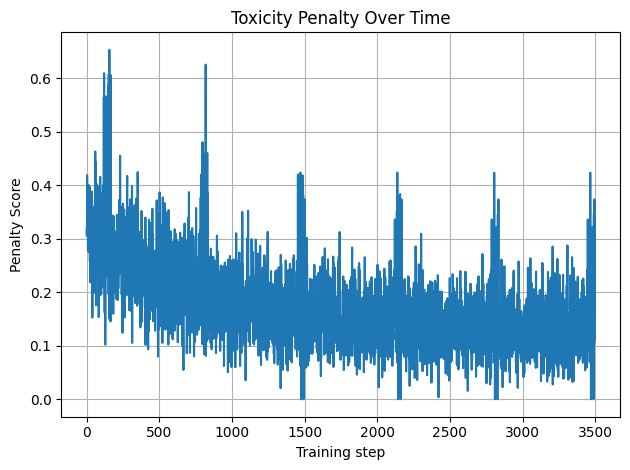

In [41]:
import matplotlib.pyplot as plt
import json

# Save logs to JSON
with open("trainer_log.json", "w", encoding="utf-8") as f:
    json.dump(trainer.state.log_history, f, indent=2)

# ✅ Now read logs back from file
with open("trainer_log.json", "r", encoding="utf-8") as f:
    logs = json.load(f)

# Extract and plot penalty scores
penalties = [log["penalty_score"] for log in logs if "penalty_score" in log]
plt.plot(penalties)
plt.xlabel("Training step")
plt.ylabel("Penalty Score")
plt.title("Toxicity Penalty Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


## Load model

In [26]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Path to your saved model
checkpoint_path = "mt5-detox-en-finetuned/checkpoint-1848"

# Load model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(checkpoint_path)
model = T5ForConditionalGeneration.from_pretrained(checkpoint_path)

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

## German to English Translation

In [13]:
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import json

# Load German-to-English model
model_name = "Helsinki-NLP/opus-mt-de-en"
tokenizer_mt = MarianTokenizer.from_pretrained(model_name)
model_mt = MarianMTModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Use formatted_de directly (already loaded as a Dataset)
toxic_de = [text.replace("detoxify: ", "") for text in formatted_de["input_text"]]
neutral_de = list(formatted_de["target_text"])

# Helper to batch translate a list of strings
def batch_translate(texts, batch_size=8):
    translations = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        inputs = tokenizer_mt(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model_mt.device)
        outputs = model_mt.generate(**inputs, max_length=128)
        decoded = tokenizer_mt.batch_decode(outputs, skip_special_tokens=True)
        translations.extend(decoded)
    return translations

# Translate both
toxic_en = batch_translate(toxic_de)
neutral_en = batch_translate(neutral_de)

# Reconstruct translated dataset
translated_data = [
    {"input_text": "detoxify: " + toxic, "target_text": neutral}
    for toxic, neutral in zip(toxic_en, neutral_en)
]

# Save to file
with open("translated_de_to_en_pairs.json", "w", encoding="utf-8") as f:
    json.dump(translated_data, f, indent=2, ensure_ascii=False)

print("✅ Translated dataset saved.")

100%|██████████| 50/50 [00:22<00:00,  2.25it/s]

✅ Translated dataset saved.


## Load German translated to english Dataset

In [27]:
from datasets import Dataset
import json

# Load raw list of strings
with open("translated_de_to_en_pairs.json", "r", encoding="utf-8") as f:
    raw_texts = json.load(f)

print("Raw texts loaded:", (raw_texts))

# Wrap each string in a dictionary
data = [
    {
        "input_text": entry.get("input_text", ""),
        "target_text": entry.get("target_text", "")
    }
    for entry in raw_texts
]

eval_dataset_de = data

print(type(eval_dataset_de))         
print(type(eval_dataset_de[0]))      

Raw texts loaded: [{'input_text': 'detoxify: #Land of the idiots #mental illness - "fight gg #Trump" (gg #Putin anyway) German # Regime in megalomania ....', 'target_text': '"Battle gg #Trump" (gg #Putin anyway) German # Regime in megalomania ....'}, {'input_text': "detoxify: #Lindner's got his head in the ass of #Merkel disgusting #FDP tonight", 'target_text': '#Lindner flatters himself again tonight #Merkel #FDP'}, {'input_text': "detoxify: Whether it's Merkel or Schulz? We Germans don't want to and can't hear this moron of plague (Merkel) and cholera (Schulz) anymore!", 'target_text': "Whether it's Merkel or Schulz? We Germans don't want and can't hear this talk from Merkel and Schulz anymore!"}, {'input_text': 'detoxify: Such a shabby rag, leaves children alone in war and flag flight', 'target_text': 'Such a person, leaves children in war alone and flag flight'}, {'input_text': "detoxify: I don't think the majority of the population is stupid or just come to your appearances?", 'ta

# Detoxification of Dataset

In [42]:
import json
from torch.utils.data import DataLoader
from transformers import T5Tokenizer
from tqdm import tqdm

def evaluate_and_save_detoxification(
    model,
    dataset,
    output_path,
    tokenizer=None,
    batch_size=12,
    lang="en"
):
    """
    Evaluates a detoxification model and saves results to a JSON file.
    
    Args:
        model: Trained T5 detoxification model.
        dataset: HuggingFace Dataset with "input_text" and "target_text".
        output_path: Path to save the JSON results.
        tokenizer: Optional tokenizer, default is T5.
        batch_size: Batch size for generation.
        lang: Language tag for progress bar.
    
    Returns:
        None
    """
    tokenizer = tokenizer or T5Tokenizer.from_pretrained("t5-small")

    def collate_fn(batch):
        texts = [ex["input_text"] for ex in batch]
        return tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    input_texts = []
    reference_texts = []
    detoxified_outputs = []

    model.eval()
    for i, batch in enumerate(tqdm(loader, desc=f"Generating Detoxified ({lang})")):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model.generate(
            **batch,
            max_length=50,
            num_beams=4,
            early_stopping=True,
            decoder_start_token_id=tokenizer.pad_token_id
        )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        detoxified_outputs.extend(decoded)

        for j in range(len(decoded)):
            example = dataset[i * batch_size + j]
            input_texts.append(example["input_text"])
            reference_texts.append(example.get("target_text", ""))

    # Save results to JSON
    result = {
        "input_texts": input_texts,
        "reference_texts": reference_texts,
        "detoxified_outputs": detoxified_outputs
    }
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)

    print(f"✅ Saved detoxified outputs to {output_path}")


## Detoxify English

In [43]:
# For English
evaluate_and_save_detoxification(
    model=model,
    dataset=eval_dataset,
    output_path="detoxified_outputs_en.json",
    tokenizer=tokenizer,
    lang="en"
)

Generating Detoxified (en): 100%|██████████| 34/34 [00:28<00:00,  1.19it/s]

✅ Saved detoxified outputs to detoxified_outputs_en.json


## Detoxify German translated to english English

In [44]:
# For German
evaluate_and_save_detoxification(
    model=model,
    dataset=eval_dataset_de,  # or eval_dataset
    output_path="detoxified_outputs_de.json",
    tokenizer=tokenizer,
    lang="de"
)

Generating Detoxified (de): 100%|██████████| 34/34 [00:45<00:00,  1.32s/it]

✅ Saved detoxified outputs to detoxified_outputs_de.json


## Translation English to German

In [49]:
with open("detoxified_outputs_de.json", "r", encoding="utf-8") as f:
    data_en = json.load(f)

print("Loaded detoxified outputs for German:", len(data_en["detoxified_outputs"]))
print("First 5 detoxified outputs:", data_en["detoxified_outputs"][:5])


Loaded detoxified outputs for German: 400
First 5 detoxified outputs: ['#Land of the idiots #mental illness - "fight gg #Trump" (gg #Putin anyway) German # Regime in megalomania', "#Lindner's got his head in the ass of #Merkel disgusting #FDP tonight", "Whether it's Merkel or Schulz? We Germans don't want to and cannot hear this moron of plague (Merkel) and cholera (Schulz) anymore!", 'Such a rag, leaves children alone in war and flag flight.', "I don't think the majority of the population is stupid or just come to your appearances?"]


In [58]:
print(type(data_en))          # Should be list
print(data_en.keys())

<class 'dict'>
dict_keys(['input_texts', 'reference_texts', 'detoxified_outputs'])


In [61]:
import json
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import torch

# Load the English-to-German translation model and tokenizer
model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer_mt = MarianTokenizer.from_pretrained(model_name)
model_mt = MarianMTModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Load the English dataset
with open("detoxified_outputs_de.json", "r", encoding="utf-8") as f:
    data_en = json.load(f)

# Extract and clean the input and target texts
toxic_en = [text.replace("detoxify: ", "") for text in data_en["input_texts"]]
neutral_en = data_en["detoxified_outputs"]

# Helper function to batch translate a list of strings
def batch_translate(texts, batch_size=8):
    translations = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Translating"):
        batch = texts[i:i + batch_size]
        inputs = tokenizer_mt(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model_mt.device)
        outputs = model_mt.generate(**inputs, max_length=128)
        decoded = tokenizer_mt.batch_decode(outputs, skip_special_tokens=True)
        translations.extend(decoded)
    return translations

# Translate both toxic and neutral texts
toxic_de = batch_translate(toxic_en)
neutral_de = batch_translate(neutral_en)

# Reconstruct the translated dataset without the "detoxify: " prefix
translated_data = [
    {"input_text": toxic, "target_text": neutral}
    for toxic, neutral in zip(toxic_de, neutral_de)
]

# Save the translated dataset to a JSON file
with open("evaluation_dataset_german.json", "w", encoding="utf-8") as f:
    json.dump(translated_data, f, indent=2, ensure_ascii=False)

print("✅ Translated dataset saved as 'evaluation_dataset_german.json'.")

Translating: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]

✅ Translated dataset saved as 'evaluation_dataset_german.json'.


# Data Evaluation

## Style Transfer Accuracy - Toxicity Level Evaluation

### reformatting detoxified outputs

In [54]:
import json

# Load the detoxified results
with open("detoxified_outputs_en.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract and clean input and output texts
input_texts = [text.replace("detoxify: ", "").strip() for text in data["input_texts"]]
detoxified_outputs = data["detoxified_outputs"]

# Create the reformatted structure
reformatted = [
    {"input_text": input_text, "target_text": detoxified}
    for input_text, detoxified in zip(input_texts, detoxified_outputs)
]

# Save to file
with open("evaluation_dataset_english.json", "w", encoding="utf-8") as f:
    json.dump(reformatted, f, indent=2, ensure_ascii=False)

print("✅ Saved as 'evaluation_dataset_english.json'")


✅ Saved as 'evaluation_dataset_english.json'


In [63]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('textdetox/xlmr-large-toxicity-classifier-v2')
model = AutoModelForSequenceClassification.from_pretrained('textdetox/xlmr-large-toxicity-classifier-v2')
model.to("cuda")  # or .to("cuda") if using GPU

def evaluate_toxicity_from_list_of_dicts(file_path: str, text_key: str = "target_text"):
    with open(file_path, "r", encoding="utf-8") as f:
        dataset = json.load(f)

    texts = [entry[text_key] for entry in dataset]
    print(f"✅ Loaded {len(texts)} texts from {file_path}")

    batch_size = 16
    toxic_count = 0
    non_toxic_count = 0

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        encodings = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        encodings = {k: v.to(model.device) for k, v in encodings.items()}

        with torch.no_grad():
            outputs = model(**encodings)

        predictions = torch.argmax(outputs.logits, dim=1)

        for label in predictions:
            if label.item() == 0:
                non_toxic_count += 1
            else:
                toxic_count += 1

    total = toxic_count + non_toxic_count
    print("\n--- Toxicity Evaluation Summary ---")
    print(f"Total texts evaluated: {total}")
    print(f"Non-toxic: {non_toxic_count} ({(non_toxic_count / total) * 100:.2f}%)")
    print(f"Toxic: {toxic_count} ({(toxic_count / total) * 100:.2f}%)")

In [64]:
evaluate_toxicity_from_list_of_dicts("evaluation_dataset_german.json", text_key="target_text")
evaluate_toxicity_from_list_of_dicts("evaluation_dataset_english.json", text_key="target_text")

✅ Loaded 400 texts from evaluation_dataset_german.json

--- Toxicity Evaluation Summary ---
Total texts evaluated: 400
Non-toxic: 216 (54.00%)
Toxic: 184 (46.00%)
✅ Loaded 400 texts from evaluation_dataset_english.json

--- Toxicity Evaluation Summary ---
Total texts evaluated: 400
Non-toxic: 271 (67.75%)
Toxic: 129 (32.25%)


## Comparison toxicity before

In [ ]:
evaluate_toxicity_from_list_of_dicts("baseline_evaluation_dataset_german.json", text_key="input_text")
evaluate_toxicity_from_list_of_dicts("baseline_evaluation_dataset_english.json", text_key="input_text")

## Content preservation: LaBSE

In [59]:
import json
import torch
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# Load LaBSE model once
labse_model = SentenceTransformer("sentence-transformers/LaBSE")

def compute_labse_similarity_from_file(filepath, input_key="input_text", target_key="target_text", sample_size=None, batch_size=16):
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)

    if sample_size:
        data = data[:sample_size]

    input_texts = [entry[input_key] for entry in data]
    target_texts = [entry[target_key] for entry in data]

    similarities = []

    for i in tqdm(range(0, len(input_texts), batch_size), desc="Computing LaBSE Similarities"):
        batch_input = input_texts[i:i+batch_size]
        batch_target = target_texts[i:i+batch_size]

        emb_input = labse_model.encode(batch_input, convert_to_tensor=True)
        emb_target = labse_model.encode(batch_target, convert_to_tensor=True)

        sim = torch.nn.functional.cosine_similarity(emb_input, emb_target).cpu().numpy()
        similarities.extend(sim)

    avg_sim = float(np.mean(similarities))
    print(f"✅ {filepath} — Content Preservation (LaBSE): {avg_sim:.4f}")
    return avg_sim, similarities


In [65]:
compute_labse_similarity_from_file("evaluation_dataset_english.json", sample_size=100)
compute_labse_similarity_from_file("evaluation_dataset_german.json", sample_size=100)


Computing LaBSE Similarities: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


✅ evaluation_dataset_english.json — Content Preservation (LaBSE): 0.9081


Computing LaBSE Similarities: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

✅ evaluation_dataset_german.json — Content Preservation (LaBSE): 0.9518


(0.9517658948898315,
 [np.float32(0.93518925),
  np.float32(1.0),
  np.float32(1.0),
  np.float32(0.92142606),
  np.float32(1.0),
  np.float32(1.0000002),
  np.float32(0.96999836),
  np.float32(0.9220258),
  np.float32(1.0),
  np.float32(0.91274977),
  np.float32(0.9048573),
  np.float32(1.0000001),
  np.float32(0.99249494),
  np.float32(1.0000001),
  np.float32(0.9811173),
  np.float32(0.98569304),
  np.float32(1.0),
  np.float32(1.0),
  np.float32(0.9758587),
  np.float32(0.9620792),
  np.float32(0.9361979),
  np.float32(0.97332346),
  np.float32(0.9899163),
  np.float32(1.0),
  np.float32(0.9258539),
  np.float32(0.9428812),
  np.float32(1.0000001),
  np.float32(0.99999994),
  np.float32(1.0),
  np.float32(0.9495358),
  np.float32(0.7641161),
  np.float32(1.0),
  np.float32(0.98087937),
  np.float32(0.9686364),
  np.float32(0.9689485),
  np.float32(1.0),
  np.float32(0.99411964),
  np.float32(0.9031936),
  np.float32(1.0),
  np.float32(1.0),
  np.float32(0.91981643),
  np.float32(0.

## Fluency Evaluation XCOMET-lite in different file

In [48]:
import json

def save_as_xcomet_input(input_texts, reference_texts, file_path):
    """
    Formats and saves input and reference texts as XCOMET input triplets.

    Parameters:
        input_texts (List[str]): Original (source) texts
        reference_texts (List[str]): Reference (target) texts
        file_path (str): Path to save the formatted JSON file
    """
    formatted = [
        {
            "src": src,
            "mt": ref,   # Here you use the reference as the hypothesis (what you're evaluating)
            "ref": ref   # And also as the gold reference (for fluency)
        }
        for src, ref in zip(input_texts, reference_texts)
    ]

    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(formatted, f, indent=2, ensure_ascii=False)


In [ ]:
# Suppose you already have your detoxified sentences and original German ones:
input_texts = evaluation_dataset_english["input_text"]       # source (e.g. German)
reference_texts = evaluation_dataset_english["target_text"]  # reference/hypothesis (e.g. detoxified English)

save_as_xcomet_input(input_texts, reference_texts, "xcomet_input_data_en.json")

# Suppose you already have your detoxified sentences and original German ones:
input_texts = evaluation_dataset_german["input_text"]       # source (e.g. German)
reference_texts = evaluation_dataset_german["target_text"]  # reference/hypothesis (e.g. detoxified English)

save_as_xcomet_input(input_texts, reference_texts, "xcomet_input_data_de.json")
